In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from scipy import integrate
from typing import Callable, List
from dataclasses import dataclass

# グラフ全体のフォント設定
plt.rcParams['font.family'] = 'serif'  # 全体のフォントをSerifに設定
plt.rcParams['mathtext.fontset'] = 'cm'  # 数式のフォントをComputer Modernに設定
plt.rcParams['mathtext.rm'] = 'serif'  # TeXの通常フォントをSerifに設定
plt.rcParams['font.size'] = 18  # デフォルトフォントサイズ
plt.rcParams['axes.labelsize'] = 18  # 軸ラベルのフォントサイズ
plt.rcParams['axes.titlesize'] = 22  # タイトルのフォントサイズ
plt.rcParams['legend.fontsize'] = 16  # 凡例のフォントサイズ
plt.rcParams['grid.color'] = 'gray'  # グリッドの色を薄い灰色に設定
plt.rcParams['grid.linestyle'] = ':'  # グリッドを点線に設定
plt.rcParams['grid.linewidth'] = 0.5  # グリッドの線幅を設定

In [2]:
np.random.seed(42)

## 棄却法
* 棄却法は望みの確率密度関数p(x)から乱数を直接生成するのが難しいときによく用いられる。

x_list: length 10000


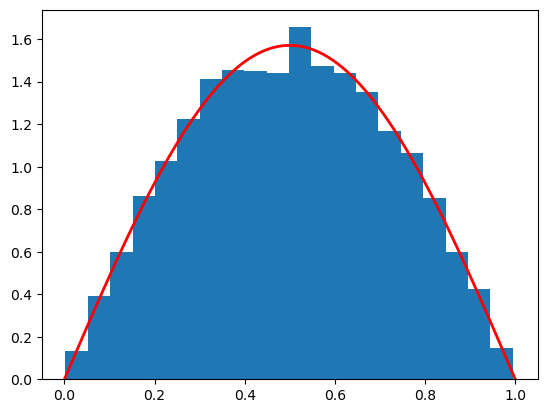

In [2]:
def rejection_sampling(p, p_star, x_star_function, alpha, depth=0):
    x_star = x_star_function()
    if depth > 100:
        return None
    U = np.random.rand()
    r = p(x_star) / (alpha * p_star(x_star))
    if U <= r:
        return x_star
    else:
        return rejection_sampling(p, p_star, x_star_function, alpha, depth+1)

t = np.linspace(0, 1, 100)
h = 1
sin_01 = lambda t: h * np.sin(np.pi * t)
x_list = []

for itr in range(10000):
    x_star = rejection_sampling(sin_01, lambda t: 1, np.random.rand, h)
    if x_star is not None:
        x_list.append(x_star)

print("x_list: length", len(x_list))

I, err = integrate.quad(lambda x: sin_01(x), min(x_list), max(x_list))

plt.hist(x_list, bins=20, density=True)
plt.plot(t, sin_01(t) / I, 'r-', lw=2, label="sin(πx)")
plt.show()

## 非定常ポアソン過程と間引き法
$$
\lambda(t) = e^{-t} \\
\lambda^{*}(t) = \max(\lambda(t))
$$
とする


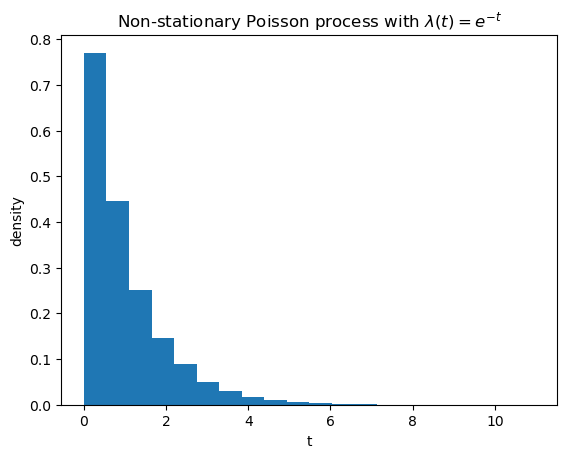

CPU times: user 2.24 s, sys: 35.5 ms, total: 2.28 s
Wall time: 1.68 s


In [3]:
%%time

def lambda_t(t):
    return np.exp(-t)

def lambda_star_t(lambda_t, t):
    return np.max(lambda_t(t))

def adoption_prob(lambda_t, lambda_star, t_star):
    return lambda_t(t_star) / lambda_star

def non_stationary_poisson_process(lambda_t, lambda_star_t, t, adoption_prob):
    lambda_star = lambda_star_t(lambda_t, t)
    t_star = 0
    i = 0

    ti = []
    tmax = max(t)

    while t_star < tmax:
        E = np.random.exponential(1/lambda_star)
        t_star += E
        if t_star > tmax:
            break
        r = adoption_prob(lambda_t, lambda_star, t_star)
        if r >= np.random.rand():
            i += 1
            ti.append(t_star)
    return ti

max_itr = 10000
t = np.linspace(0, 100, 1000)
ti_list = []

for itr in range(max_itr):
    ti = non_stationary_poisson_process(lambda_t, lambda_star_t, t, adoption_prob)
    ti_list.append(ti)

flat_ti_list = [item for sublist in ti_list for item in sublist]
plt.hist(flat_ti_list, bins=20, density=True)
# plt.yscale("log")
plt.xlabel("t")
plt.ylabel("density")
plt.title(r"Non-stationary Poisson process with $\lambda(t)=e^{-t}$")
plt.show()



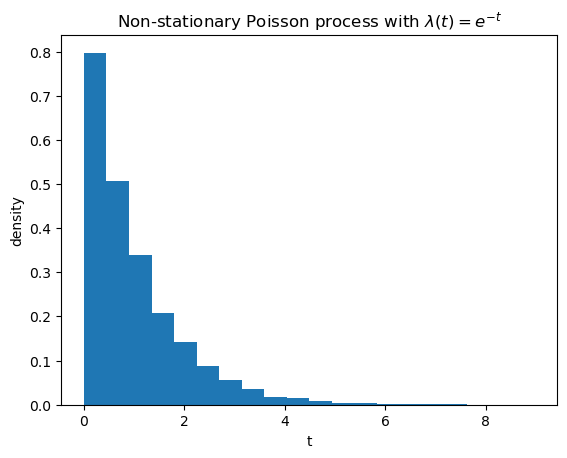

CPU times: user 1.61 s, sys: 18.3 ms, total: 1.63 s
Wall time: 1.2 s


In [4]:
%%time
def lambda_star_t(lambda_t, t, t_star):
    return np.max(lambda_t(t[t_star < t]))

def non_stationary_poisson_process(lambda_t, lambda_star_t, t, adoption_prob):
    t_star = 0
    i = 0
    ti = []
    tmax = max(t)
    lambda_star = lambda_star_t(lambda_t, t, t_star)
    while t_star < tmax:
        E = np.random.exponential(1/lambda_star)
        t_star += E
        if t_star > tmax:
            break
        r = adoption_prob(lambda_t, lambda_star, t_star)
        if r >= np.random.rand():
            i += 1
            ti.append(t_star)
            lambda_star = lambda_star_t(lambda_t, t, t_star)
            
    return ti

ti_list = []

for itr in range(max_itr):
    ti = non_stationary_poisson_process(lambda_t, lambda_star_t, t, adoption_prob)
    ti_list.append(ti)

flat_ti_list = [item for sublist in ti_list for item in sublist]
plt.hist(flat_ti_list, bins=20, density=True)
plt.xlabel("t")
plt.ylabel("density")
plt.title(r"Non-stationary Poisson process with $\lambda(t)=e^{-t}$")
plt.show()

## ホークス過程のシミュレーション
* カーネル関数が指数関数$h(\tau)=ab\exp(-b\tau)$の場合には、条件付き強度関数の値は$\lambda(t^*|H_{t^*})=\rho + (\lambda^* - \rho)\exp(-bE)$

In [70]:
@dataclass
class HawkesParams:
    kernel: Callable[[float], float]
    rho: float
    a: float
    b: float

    @property
    def initial_intensity(self) -> np.ndarray:
        """Initial intensity."""
        return self.rho

a: 0.2, len(ti): 16
a: 1.0, len(ti): 139
a: 1.1, len(ti): 539


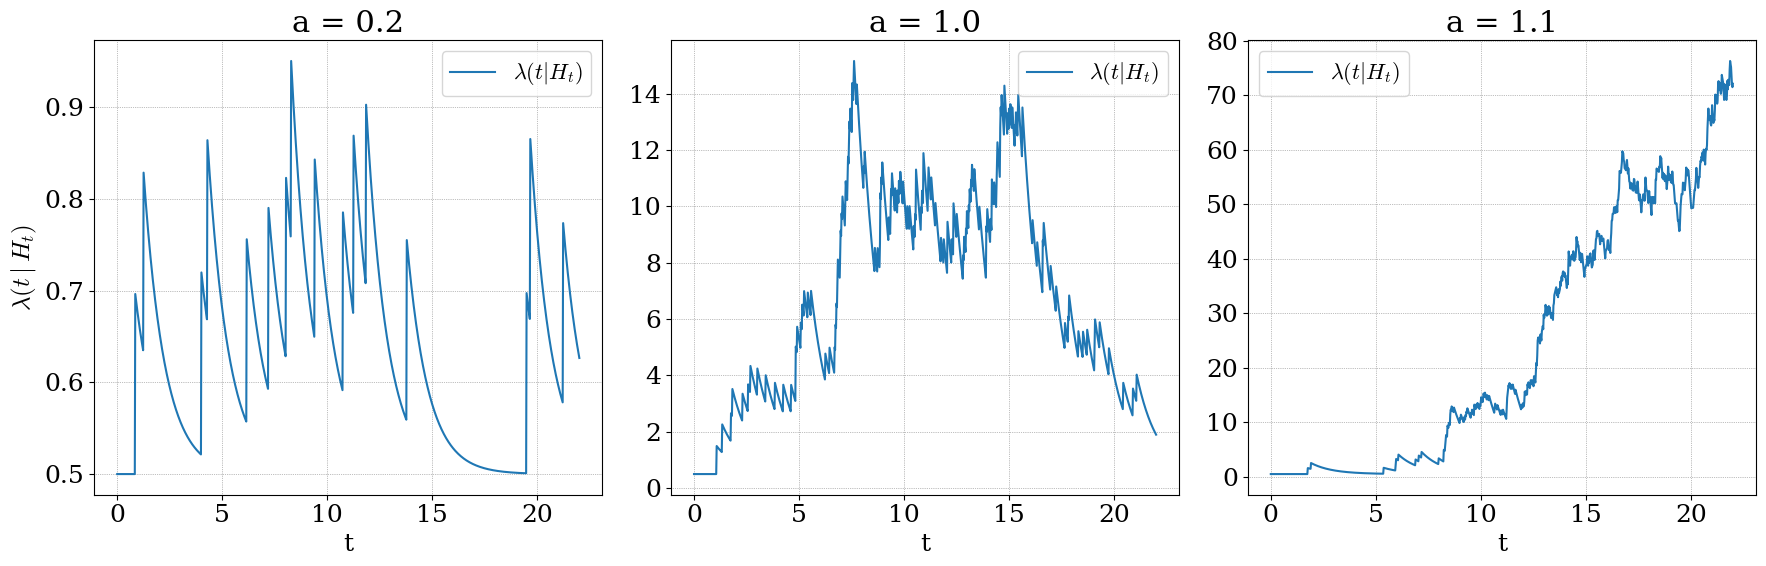

In [73]:
# Kernel and conditional intensity function
def kernel(tau: float, p: HawkesParams) -> float:
    """Exponential kernel h(τ)."""
    return p.a * p.b * np.exp(-p.b * tau) * (tau >= 0)

def lamb(t: np.ndarray, history: np.ndarray, p: HawkesParams) -> np.ndarray:
    """Conditional intensity function."""
    dt = t[:, None] - history[None, :]
    return p.rho + kernel(dt, p).sum(axis=1)

def thinning_rate(lamb_star: float, elapced: float, p: HawkesParams) -> float:
    """Next intensity."""
    return p.rho + (lamb_star - p.rho) * np.exp(-p.b * elapced)

# Simulation
def simulate_hawkes(timespan: np.ndarray, p: HawkesParams) -> np.ndarray:
    """Simulate Hawkes process."""

    # 初期化
    t_max = timespan[-1]
    t_star = 0
    lamb_star = p.initial_intensity
    ti: List[float] = []

    # 次のイベントが起きるまでの時間をサンプリング
    while t_star < t_max:
        wait = np.random.exponential(1/lamb_star)
        t_star += wait
        if t_star > t_max:
            break

        # サンプリングした時間にイベントが起きたとするかどうか判定
        current_intensity = thinning_rate(lamb_star, wait, p)
        accept_prob =  current_intensity / lamb_star
        if accept_prob >= np.random.rand():
            ti.append(t_star)
            lamb_star = current_intensity + kernel(0, p)
        else:
            lamb_star = current_intensity

    return np.array(ti)

def main() -> None:
    t = np.linspace(0, 22, 1000)
    a_values = [0.2, 1.0, 1.1]

    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(a_values),
        figsize=(6 * len(a_values), 6),
    )

    for ax, a in zip(axes, a_values):
        params = HawkesParams(a=a, b=1, rho=0.5, kernel=kernel)
        ti = simulate_hawkes(t, params)
        print(f"a: {a}, len(ti): {len(ti)}")
        # lambs = lamb(ti, ti, params)
        lam_t  = lamb(t, ti, params)

        # ax.scatter(ti, lambs, s=3, color="tab:blue")
        ax.plot(t, lam_t, color="tab:blue", label=r"$\lambda(t|H_t)$")
        ax.set_xlabel("t")
        ax.set_title(f"a = {a}")
        ax.grid(linestyle=":")
        ax.legend()

    axes[0].set_ylabel(r"$\lambda(t \mid H_t)$")
    fig.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


## 多次元ホークス過程のシミュレーション
* イベント$i$の条件付き強度関数の値は、

$$
\lambda_i(t^*|H_{t^*})=\rho_i + \sum_{j=1}^{N}a_{ij}\sum_{t_j^k<t^*}h(t^*-t_j^k)
$$

* $N$: 頂点数
* $a_{ij}$: 隣接行列の$(i, j)$成分
* $t_j^k$: 頂点$j$の$k$回目のイベントの発生時刻

In [37]:
@dataclass
class HawkesParams:
    kernel: Callable[[float], float]
    dim: int
    rho: float
    a: float
    b: float

    a_ij: float

    @property
    def initial_intensity(self) -> np.ndarray:
        """Initial intensity."""
        return np.ones(self.dim) * self.rho
    
@dataclass
class Network:
    N: int
    k_ave: float
    edge_list: np.ndarray
    addless_list: np.ndarray
    cursor_list: np.ndarray

N: 1000, <k>: 10.03


a: 0.001, t_star: 22.909: : 22.909288214653998it [00:00, 2497.49it/s]                        
a: 0.01, t_star: 22.024: 100%|##########| 22.023622696864926/22.0 [00:00<00:00, 2368.13it/s]
a: 0.1, t_star: 22.012: 100%|##########| 22.012392125367306/22.0 [00:00<00:00, 164.27it/s]


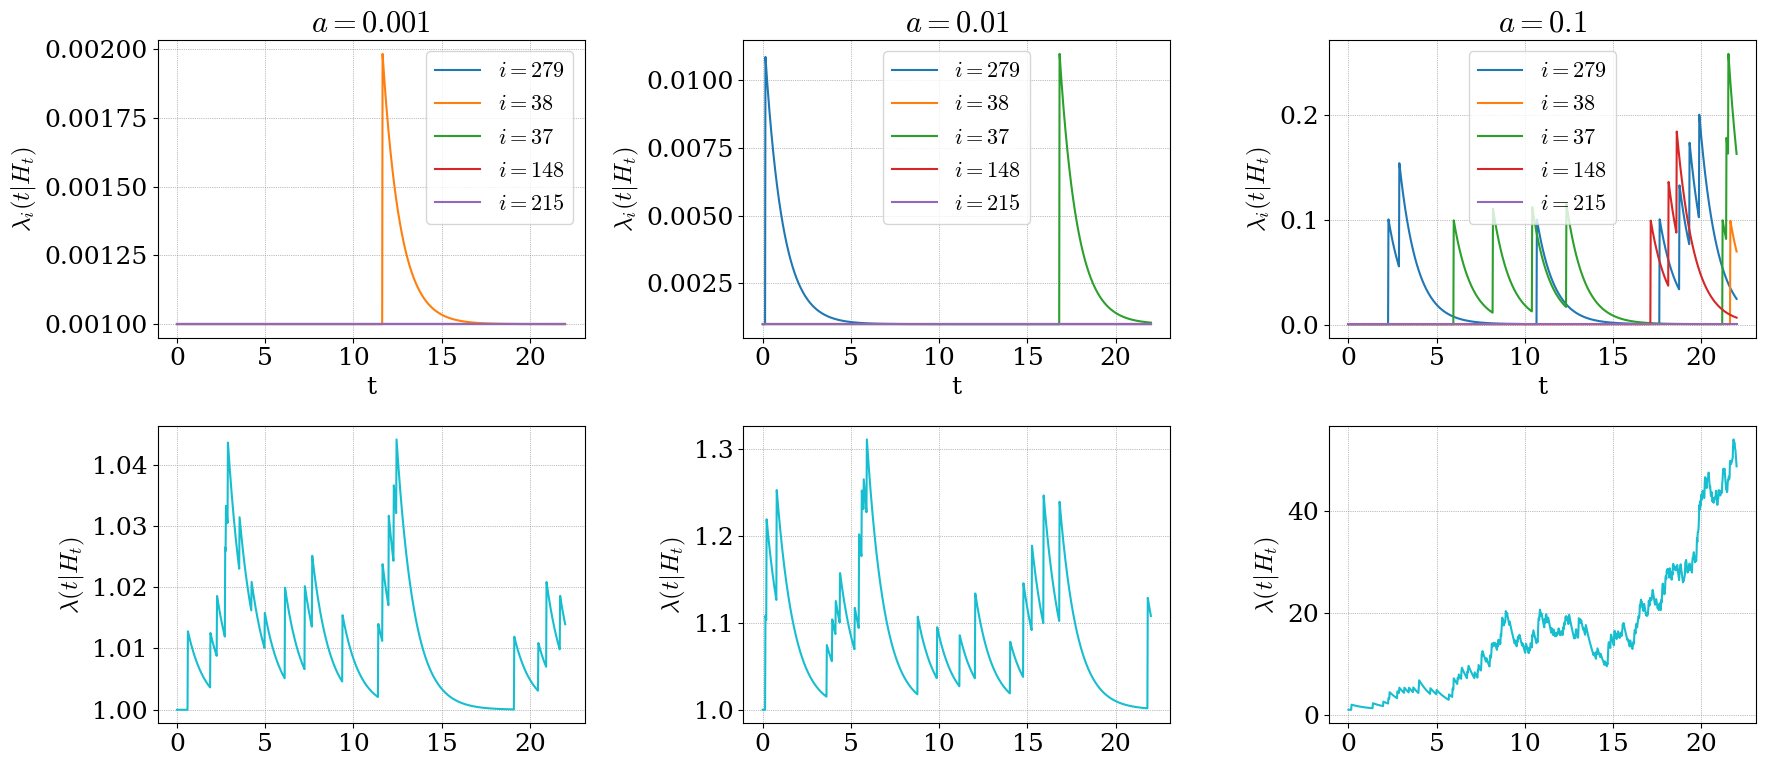

In [64]:
def create_er_network(N: int, p: float) -> Network:
    g = nx.erdos_renyi_graph(N, p)
    k_ave = np.mean([len(list(g.neighbors(node))) for node in g.nodes])
    edge_list = np.zeros(2*g.number_of_edges(), dtype=int)
    addless_list = np.zeros(N, dtype=int)
    cursor_list = np.zeros(N, dtype=int)

    for i in range(N-1):
        node = list(g.nodes)[i]
        addless_list[node + 1] = addless_list[node] + len(list(g.neighbors(node)))
        cursor_list[node + 1] = addless_list[node + 1]
    
    for edge in list(g.edges):
        edge_list[cursor_list[edge[0]]] = edge[1]
        edge_list[cursor_list[edge[1]]] = edge[0]
        cursor_list[edge[0]] += 1
        cursor_list[edge[1]] += 1

    return Network(g.number_of_nodes(), k_ave, edge_list, addless_list, cursor_list)

# Kernel and conditional intensity function
def kernel(tau: float, p: HawkesParams) -> float:
    """Exponential kernel h(τ)."""
    return p.a * p.b * np.exp(-p.b * tau) * (tau >= 0)

def lamb_i(i: int, t: np.ndarray, event_times: List[float], event_nodes: List[int], p: HawkesParams, g: Network) -> np.ndarray:
    """Conditional intensity function."""
    dim_i = g.cursor_list[i] - g.addless_list[i]
    dt = np.zeros((dim_i, len(event_times)))

    sigma_j = np.zeros((dim_i, len(t)))

    for jidx in range(dim_i):
        j = g.edge_list[g.addless_list[i] + jidx]
        history = []
        for eidx, et in enumerate(event_times):
            if event_nodes[eidx] == j:
                history.append(et)
        dt = t[:, None] - np.array(history)[None, :]
        sigma_j[jidx, :] = kernel(dt, p).sum(axis=1)

    return p.rho[i] + sigma_j.sum(axis=0) * p.a_ij

def thinning_rate(lamb_star: np.ndarray, elapsed: float, p: HawkesParams, g: Network) -> np.ndarray:
    """Conditional intensity function."""
    return p.rho + (lamb_star - p.rho) * np.exp(-p.b * elapsed)

# Simulation
def simulate_hawkes_with_network(timespan: np.ndarray, p: HawkesParams, g: Network, max_events: int = 10000) -> np.ndarray:
    """Simulate Hawkes process."""

    # 初期化
    t_max = timespan[-1]
    t_star = 0
    lamb_star = np.ones(g.N) * p.rho
    event_times: List[float] = []
    event_nodes: List[int] = []

    pbar = tqdm(total=t_max, ascii=True)
    pbar.set_description(f"a: {p.a}, t_star: {t_star:.3f}")

    # 次のイベントが起きるまでの時間をサンプリング
    while t_star < t_max:
        wait = np.random.exponential(1/lamb_star.sum())
        t_star += wait

        pbar.update(wait)
        pbar.set_description(f"a: {p.a}, t_star: {t_star:.3f}")
        if t_star > t_max:
            break

        # サンプリングした時間にイベントが起きたとするかどうか判定
        current_intensity = thinning_rate(lamb_star, wait, p, g)
        accept_prob =  current_intensity.sum() / lamb_star.sum()
        if accept_prob >= np.random.rand():
            event_times.append(t_star)
            node = np.random.choice(range(p.dim), p=current_intensity / current_intensity.sum())
            event_nodes.append(int(node))
            
            lamb_star = current_intensity
            for neighbor in g.edge_list[g.addless_list[node]:g.cursor_list[node]]:
                lamb_star[neighbor] += kernel(0, p) * p.a_ij # カーネル関数は全ての次元で同じとしている。
            if len(event_times) > max_events:
                break
        else:
            lamb_star = current_intensity

    pbar.close()

    return np.array(event_times), np.array(event_nodes)

def main() -> None:
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]

    N: int = 1000
    g: Network = create_er_network(N, 0.01)
    print(f"N: {g.N}, <k>: {g.k_ave}")

    t = np.linspace(0, 22, 1000)
    a_values = np.array([0.001, 0.01, 0.1])

    iidx_list = np.random.choice(range(g.N), size=5, replace=False)

    fig, axes = plt.subplots(
        nrows=2,
        ncols=len(a_values),
        figsize=(6 * len(a_values), 8),
    )

    for aidx, a in enumerate(a_values):

        params = HawkesParams(dim=g.N, a=a, b=1, rho=np.ones(g.N)/g.N, a_ij=1, kernel=kernel)
        event_times, event_nodes = simulate_hawkes_with_network(t, params, g)

        for iidx, i in enumerate(iidx_list):
            lam_i_t  = lamb_i(i, t, event_times, event_nodes, params, g)

            # ax.scatter(ti, lambs, s=3, color="tab:blue")
            axes[0, aidx].plot(t, lam_i_t, color=colors[iidx], label=rf"$i = {i}$")
        axes[0, aidx].set_xlabel("t")
        axes[0, aidx].set_ylabel(rf"$\lambda_i(t|H_t)$")
        axes[0, aidx].set_title(rf"$a = {a}$")
        axes[0, aidx].grid(linestyle=":")
        axes[0, aidx].legend()

        lam_t = np.array([lamb_i(i, t, event_times, event_nodes, params, g) for i in range(g.N)]).sum(axis=0)
        axes[1, aidx].plot(t, lam_t, color=colors[-1])
        axes[1, aidx].set_ylabel(rf"$\lambda(t|H_t)$")
        axes[1, aidx].grid(linestyle=":")
    fig.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
